In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lish-moa/test_features.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv
/kaggle/input/lish-moa/sample_submission.csv


In [3]:
! pip install iterative-stratification

In [4]:
        
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau



import numpy as np 
import pandas as pd 
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, tnrange

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

plt.rcParams['figure.figsize'] = 25, 7

CGREEN  = '\33[32m'
CBLUE =  '\033[34m'
CRED = '\033[1;31m'
CEND  = '\33[0m'

def seed_everything(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [8]:
if torch.cuda.is_available():
    device='cuda'
else:
    device='cpu'
    
device

'cuda'

In [9]:

train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets = pd.read_csv('../input/lish-moa/train_targets_scored.csv')

test_features = pd.read_csv('../input/lish-moa/test_features.csv')


In [10]:
def preprocess(df):
    df = df.copy()
    df.loc[:, 'cp_type'] = df.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
    df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
    return df

train = preprocess(train_features)
test = preprocess(test_features)

del train_targets['sig_id']

target = train_targets.loc[train['cp_type']==0].reset_index(drop=True)
train = train.loc[train['cp_type']==0].reset_index(drop=True)

In [12]:
top_features = [  1,   2,   3,   4,   5,   6,   7,   9,  11,  14,  15,  16,  17,
        18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  29,  30,  31,
        32,  33,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  46,
        47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  78,  79,  80,  81,  82,  83,  84,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
       184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197,
       198, 199, 200, 202, 203, 204, 205, 206, 208, 209, 210, 211, 212,
       213, 214, 215, 216, 217, 218, 219, 220, 221, 223, 224, 225, 226,
       227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239,
       240, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253,
       254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266,
       267, 268, 269, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280,
       281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 294,
       295, 296, 298, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309,
       310, 311, 312, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323,
       324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336,
       337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349,
       350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362,
       363, 364, 365, 366, 367, 368, 369, 370, 371, 374, 375, 376, 377,
       378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 390, 391,
       392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404,
       405, 406, 407, 408, 409, 411, 412, 413, 414, 415, 416, 417, 418,
       419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431,
       432, 434, 435, 436, 437, 438, 439, 440, 442, 443, 444, 445, 446,
       447, 448, 449, 450, 453, 454, 456, 457, 458, 459, 460, 461, 462,
       463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475,
       476, 477, 478, 479, 481, 482, 483, 484, 485, 486, 487, 488, 489,
       490, 491, 492, 493, 494, 495, 496, 498, 500, 501, 502, 503, 505,
       506, 507, 509, 510, 511, 512, 513, 514, 515, 518, 519, 520, 521,
       522, 523, 524, 525, 526, 527, 528, 530, 531, 532, 534, 535, 536,
       538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 549, 550, 551,
       552, 554, 557, 559, 560, 561, 562, 565, 566, 567, 568, 569, 570,
       571, 572, 573, 574, 575, 577, 578, 580, 581, 582, 583, 584, 585,
       586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 599,
       600, 601, 602, 606, 607, 608, 609, 611, 612, 613, 615, 616, 617,
       618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630,
       631, 632, 633, 634, 635, 636, 637, 638, 639, 641, 642, 643, 644,
       645, 646, 647, 648, 649, 650, 651, 652, 654, 655, 656, 658, 659,
       660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672,
       673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685,
       686, 687, 688, 689, 691, 692, 693, 694, 695, 696, 697, 699, 700,
       701, 702, 704, 705, 707, 708, 709, 710, 711, 713, 714, 716, 717,
       718, 720, 721, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732,
       733, 734, 735, 737, 738, 739, 740, 742, 743, 744, 745, 746, 747,
       748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 759, 760, 761,
       762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774,
       775, 776, 777, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788,
       789, 790, 792, 793, 794, 795, 796, 797, 798, 800, 801, 802, 803,
       804, 805, 806, 808, 809, 811, 813, 814, 815, 816, 817, 818, 819,
       821, 822, 823, 825, 826, 827, 828, 829, 830, 831, 832, 834, 835,
       837, 838, 839, 840, 841, 842, 845, 846, 847, 848, 850, 851, 852,
       854, 855, 856, 858, 859, 860, 861, 862, 864, 866, 867, 868, 869,
       870, 871, 872, 873, 874]

In [13]:
all_columns = train.columns
train=train[all_columns[top_features]]
test = test[all_columns[top_features]]

In [14]:
train = train.values
test = test.values
target = target.values


In [15]:
train.shape, test.shape, target.shape

((21948, 785), (3982, 785), (21948, 206))

In [17]:
class TrainDataset(Dataset):
    def __init__(self, train,targets, noise ):
        
        self.features  = train
        self.targets = targets
        self.noise = noise
        
    def sizes(self):
        print("features size = ", self.features.shape[1])
        print("targets size = ", self.targets.shape[1])

        
    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx]).float()
        
#         if self.noise == True:
# #             print("noisy boi")
#             feature  = feature + torch.randn_like(feature)/150
            
        target = torch.tensor(self.targets[idx]).float()
        
        return feature, target

In [18]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        
def show_lr(learning_rates):
    plt.plot(learning_rates, label = "learning rate")
    plt.ylabel("Learning rate", fontsize = 15)
    plt.grid(True)
    plt.legend()
    plt.show()

def train_step(x, y, model, optimizer, criterion):
    optimizer.zero_grad()
    pred = model(x.to(device))
    y = y.float()
    loss = criterion(pred,y.to(device))
    loss.backward()
    optimizer.step()
    return loss.item()

## Train test split for testing 

In [19]:
def validate_fn(model, val_loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for batch in val_loader:
            x, y = batch 
            pred = model(x.to(device))
            loss = criterion(pred.cpu(),y).item()
            losses.append(loss)
    return np.array(losses).mean()

def create_weights_from_val_losses(val_losses_np):
    w = 1/val_losses_np
    w_norm = w/w.max()
    return w_norm


def train_one_fold(model,num_epochs , train_loader,val_loader, optimizer, scheduler, criterion, fold_number = 1, show_plots = False, train = True, validate = True):
    
    losses = []
    val_losses = []
    learning_rates = []    
    best_loss = 1000000

    for epoch in range(num_epochs):

            
        if train == True:
            model.train()
            losses_temp = []
            for batch in train_loader:
                (x_batch, y_batch) = batch
                loss = train_step(x_batch.to(device), y_batch.to(device), model, optimizer, criterion)
                losses_temp.append(loss)
            losses.append(torch.mean(torch.tensor(losses_temp)))
            
            if scheduler is not None:
                scheduler.step(1.)   ## lr decay caller 

            learning_rates.append(get_lr(optimizer))
            

        if validate == True:
            val_losses.append(validate_fn(model, val_loader, criterion, device))
            

        
        if train == True:
            print ("epoch ", epoch+1, " out of ", num_epochs, end = "      >" )

            if val_losses[-1] <= best_loss:

                print(CGREEN, "Val loss decreased from:", best_loss, " to ", val_losses[-1], CEND, end = "   >")
                best_loss = val_losses[-1]
                name = "./model_" + str(fold_number)+".pth"
                print("saving model as: ", name)
                torch.save(model.state_dict(), name)

            else: 
                print("showing no improvements, best loss yet:", best_loss)

        if show_plots == True:

            show_lr(learning_rates)
            plt.plot(val_losses, label = "val")
            plt.axhline(min(val_losses), linestyle = "--", c = "r")
            plt.legend()
            plt.grid()
            plt.show()


            plt.plot(val_losses[4:], label = "val after main drop", c = "g")
            plt.axhline(min(val_losses), linestyle = "--", c = "r")
            plt.legend()
            plt.grid()
            plt.show()


            plt.plot(losses, label = "train")
            plt.legend()
            plt.grid()
            plt.show()
        
    if train == True:
        return min(val_losses), name
    else:
        return min(val_losses)

## Creating folds for training 

In [52]:
train_main = train[:-2000]
target_main = target[:-2000]

train_hold = train[-2000:]
target_hold = target[-2000:]

hold_dataset = TrainDataset(train_hold, target_hold, noise = False)
hold_loader = DataLoader(dataset=hold_dataset, batch_size=512, shuffle= False)

In [53]:
num_folds = 5

mskf = MultilabelStratifiedKFold(n_splits=num_folds, shuffle=True, random_state=0)

train_loaders = []
val_loaders = []

for k , (train_idx,valid_idx) in enumerate(mskf.split(train_main,target_main)):

    x_train,x_valid,y_train,y_valid = train_main[train_idx,:],train_main[valid_idx,:],target_main[train_idx,:],target_main[valid_idx,:]

    input_size = x_train.shape[1]
    output_size = target.shape[1]


    train_dataset = TrainDataset(x_train, y_train, noise = False)
    valid_dataset = TrainDataset(x_valid, y_valid, noise = False)

    train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

    val_loader = DataLoader(dataset=valid_dataset, batch_size=256, shuffle = False)
    
    train_loaders.append(train_loader)
    val_loaders.append(val_loader)

print(len(train_loader), "batches ")
print(len(val_loader), " batches ")

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


125 batches 
16  batches 


# Model 1 

In [54]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(785)
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.utils.weight_norm(nn.Linear(785, 2048))
        
        self.batch_norm2 = nn.BatchNorm1d(2048)
        self.dropout2 = nn.Dropout(0.5)
        self.dense2 = nn.utils.weight_norm(nn.Linear(2048, 1048))
        
        self.batch_norm3 = nn.BatchNorm1d(1048)
        self.dropout3 = nn.Dropout(0.5)
        self.dense3 = nn.utils.weight_norm(nn.Linear(1048, 206))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)
        
        return x

# Model 1 training 

In [55]:
model_filenames = []
val_losses = []
model_classes = []

num_epochs = 45 ## changes here 

k = 0
for train_loader, val_loader in zip(train_loaders,val_loaders):
    model = Model()
    model_classes.append(Model())
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr = 0.004299882049752947, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                     mode='min', 
                                                     factor=0.1, ## wooo hoo
                                                     patience=7, ## was 3 for 158 
                                                     eps=1e-4, 
                                                     verbose=True)


    criterion = nn.BCEWithLogitsLoss()

    val_loss, filename = train_one_fold(model, num_epochs , train_loader,val_loader, optimizer, scheduler, criterion, fold_number = k+1)
    
    print("hold loss: ", str(validate_fn(model, hold_loader, criterion, device)))
    val_losses.append(val_loss)
    model_filenames.append(filename)
    k+=1
    
print(CBLUE, "Training complete", CEND)

epoch  1  out of  45      > Val loss decreased from: 1000000  to  0.021175343194045126    >saving model as:  ./model_1.pth
epoch  2  out of  45      > Val loss decreased from: 0.021175343194045126  to  0.019533749436959624    >saving model as:  ./model_1.pth
epoch  3  out of  45      > Val loss decreased from: 0.019533749436959624  to  0.0186537824338302    >saving model as:  ./model_1.pth
epoch  4  out of  45      > Val loss decreased from: 0.0186537824338302  to  0.018207067158073187    >saving model as:  ./model_1.pth
epoch  5  out of  45      > Val loss decreased from: 0.018207067158073187  to  0.017923658131621778    >saving model as:  ./model_1.pth
epoch  6  out of  45      > Val loss decreased from: 0.017923658131621778  to  0.017546408460475504    >saving model as:  ./model_1.pth
epoch  7  out of  45      > Val loss decreased from: 0.017546408460475504  to  0.01738505286630243    >saving model as:  ./model_1.pth
epoch  8  out of  45      > Val loss decreased from: 0.01738505286

epoch  22  out of  45      > Val loss decreased from: 0.016294178494717926  to  0.0162855667877011    >saving model as:  ./model_2.pth
epoch  23  out of  45      > Val loss decreased from: 0.0162855667877011  to  0.016281219897791743    >saving model as:  ./model_2.pth
epoch  24  out of  45      > Val loss decreased from: 0.016281219897791743  to  0.016274928639177233    >saving model as:  ./model_2.pth
epoch  25  out of  45      >showing no improvements, best loss yet: 0.016274928639177233
epoch  26  out of  45      > Val loss decreased from: 0.016274928639177233  to  0.01626779674552381    >saving model as:  ./model_2.pth
epoch  27  out of  45      >showing no improvements, best loss yet: 0.01626779674552381
epoch  28  out of  45      >showing no improvements, best loss yet: 0.01626779674552381
epoch  29  out of  45      >showing no improvements, best loss yet: 0.01626779674552381
epoch  30  out of  45      >showing no improvements, best loss yet: 0.01626779674552381
epoch  31  out o

epoch  4  out of  45      > Val loss decreased from: 0.018675613682717085  to  0.01788568851770833    >saving model as:  ./model_4.pth
epoch  5  out of  45      > Val loss decreased from: 0.01788568851770833  to  0.017412369430530816    >saving model as:  ./model_4.pth
epoch  6  out of  45      > Val loss decreased from: 0.017412369430530816  to  0.01733173429965973    >saving model as:  ./model_4.pth
epoch  7  out of  45      > Val loss decreased from: 0.01733173429965973  to  0.01714858243940398    >saving model as:  ./model_4.pth
epoch  8  out of  45      >showing no improvements, best loss yet: 0.01714858243940398
Epoch     9: reducing learning rate of group 0 to 4.2999e-04.
epoch  9  out of  45      > Val loss decreased from: 0.01714858243940398  to  0.017114823684096336    >saving model as:  ./model_4.pth
epoch  10  out of  45      > Val loss decreased from: 0.017114823684096336  to  0.016533255577087402    >saving model as:  ./model_4.pth
epoch  11  out of  45      > Val loss de

epoch  25  out of  45      >showing no improvements, best loss yet: 0.01613401557551697
epoch  26  out of  45      > Val loss decreased from: 0.01613401557551697  to  0.01611084456089884    >saving model as:  ./model_5.pth
epoch  27  out of  45      >showing no improvements, best loss yet: 0.01611084456089884
epoch  28  out of  45      > Val loss decreased from: 0.01611084456089884  to  0.016108354786410928    >saving model as:  ./model_5.pth
epoch  29  out of  45      >showing no improvements, best loss yet: 0.016108354786410928
epoch  30  out of  45      >showing no improvements, best loss yet: 0.016108354786410928
epoch  31  out of  45      >showing no improvements, best loss yet: 0.016108354786410928
epoch  32  out of  45      >showing no improvements, best loss yet: 0.016108354786410928
epoch  33  out of  45      >showing no improvements, best loss yet: 0.016108354786410928
epoch  34  out of  45      > Val loss decreased from: 0.016108354786410928  to  0.016108169918879867    >sav

In [56]:
model_filenames

['./model_1.pth',
 './model_2.pth',
 './model_3.pth',
 './model_4.pth',
 './model_5.pth']

# Model 2 

In [57]:
class Model_2(nn.Module):
    def __init__(self):
        super(Model_2, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(785)
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.utils.weight_norm(nn.Linear(785, 512))
        
        self.batch_norm4 = nn.BatchNorm1d(512)
        self.dropout4 = nn.Dropout(0.5)
        self.dense4 = nn.utils.weight_norm(nn.Linear(512, 206))
    
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.leaky_relu(self.dense1(x))
        
        x = self.batch_norm4(x)
        x = self.dropout4(x)
        x = self.dense4(x)
        
        return x

# Model 2 training

In [58]:
num_epochs = 60 ## changes here 



k = 0
for train_loader, val_loader in zip(train_loaders,val_loaders):
    model = Model_2()
    model_classes.append(Model_2())
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr = 4e-3, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                     mode='min', 
                                                     factor=0.1, ## wooo hoo
                                                     patience=7, ## was 3 for 158 
                                                     eps=1e-4, 
                                                     verbose=True)


    criterion = nn.BCEWithLogitsLoss()

    val_loss, filename = train_one_fold(model, num_epochs , train_loader,val_loader, optimizer, scheduler, criterion, fold_number = 100 + k + 1)
    print("hold loss: ", str(validate_fn(model, hold_loader, criterion, device)))


    val_losses.append(val_loss)
    model_filenames.append(filename)
    
    k+=1
    
print(CBLUE, "Training complete", CEND)

epoch  1  out of  60      > Val loss decreased from: 1000000  to  0.022218630998395383    >saving model as:  ./model_101.pth
epoch  2  out of  60      > Val loss decreased from: 0.022218630998395383  to  0.01938389427959919    >saving model as:  ./model_101.pth
epoch  3  out of  60      > Val loss decreased from: 0.01938389427959919  to  0.01859833812341094    >saving model as:  ./model_101.pth
epoch  4  out of  60      > Val loss decreased from: 0.01859833812341094  to  0.018010772997513413    >saving model as:  ./model_101.pth
epoch  5  out of  60      > Val loss decreased from: 0.018010772997513413  to  0.017675239127129316    >saving model as:  ./model_101.pth
epoch  6  out of  60      > Val loss decreased from: 0.017675239127129316  to  0.01750567415729165    >saving model as:  ./model_101.pth
epoch  7  out of  60      > Val loss decreased from: 0.01750567415729165  to  0.017375483294017613    >saving model as:  ./model_101.pth
epoch  8  out of  60      > Val loss decreased from: 

epoch  9  out of  60      > Val loss decreased from: 0.017330446746200323  to  0.017240734887309372    >saving model as:  ./model_102.pth
epoch  10  out of  60      > Val loss decreased from: 0.017240734887309372  to  0.016912514925934374    >saving model as:  ./model_102.pth
epoch  11  out of  60      > Val loss decreased from: 0.016912514925934374  to  0.016812011250294745    >saving model as:  ./model_102.pth
epoch  12  out of  60      > Val loss decreased from: 0.016812011250294745  to  0.016776561620645225    >saving model as:  ./model_102.pth
epoch  13  out of  60      > Val loss decreased from: 0.016776561620645225  to  0.016708800103515387    >saving model as:  ./model_102.pth
epoch  14  out of  60      > Val loss decreased from: 0.016708800103515387  to  0.01667294919025153    >saving model as:  ./model_102.pth
epoch  15  out of  60      > Val loss decreased from: 0.01667294919025153  to  0.01663388591259718    >saving model as:  ./model_102.pth
epoch  16  out of  60      > Va

epoch  15  out of  60      > Val loss decreased from: 0.01670470181852579  to  0.016666779527440667    >saving model as:  ./model_103.pth
epoch  16  out of  60      > Val loss decreased from: 0.016666779527440667  to  0.016663103830069304    >saving model as:  ./model_103.pth
Epoch    17: reducing learning rate of group 0 to 4.0000e-05.
epoch  17  out of  60      > Val loss decreased from: 0.016663103830069304  to  0.016640220186673105    >saving model as:  ./model_103.pth
epoch  18  out of  60      > Val loss decreased from: 0.016640220186673105  to  0.01662691484671086    >saving model as:  ./model_103.pth
epoch  19  out of  60      > Val loss decreased from: 0.01662691484671086  to  0.016600849106907845    >saving model as:  ./model_103.pth
epoch  20  out of  60      >showing no improvements, best loss yet: 0.016600849106907845
epoch  21  out of  60      > Val loss decreased from: 0.016600849106907845  to  0.01658535358728841    >saving model as:  ./model_103.pth
epoch  22  out of  

epoch  20  out of  60      > Val loss decreased from: 0.01629886741284281  to  0.016289839695673436    >saving model as:  ./model_104.pth
epoch  21  out of  60      > Val loss decreased from: 0.016289839695673436  to  0.016285117832012475    >saving model as:  ./model_104.pth
epoch  22  out of  60      > Val loss decreased from: 0.016285117832012475  to  0.016276714450214058    >saving model as:  ./model_104.pth
epoch  23  out of  60      > Val loss decreased from: 0.016276714450214058  to  0.016272793523967266    >saving model as:  ./model_104.pth
epoch  24  out of  60      > Val loss decreased from: 0.016272793523967266  to  0.016270700260065496    >saving model as:  ./model_104.pth
epoch  25  out of  60      > Val loss decreased from: 0.016270700260065496  to  0.016267443832475692    >saving model as:  ./model_104.pth
epoch  26  out of  60      > Val loss decreased from: 0.016267443832475692  to  0.016259387892205268    >saving model as:  ./model_104.pth
epoch  27  out of  60      >

epoch  28  out of  60      > Val loss decreased from: 0.01632117643021047  to  0.016306463687215    >saving model as:  ./model_105.pth
epoch  29  out of  60      >showing no improvements, best loss yet: 0.016306463687215
epoch  30  out of  60      > Val loss decreased from: 0.016306463687215  to  0.016300406132359058    >saving model as:  ./model_105.pth
epoch  31  out of  60      >showing no improvements, best loss yet: 0.016300406132359058
epoch  32  out of  60      >showing no improvements, best loss yet: 0.016300406132359058
epoch  33  out of  60      >showing no improvements, best loss yet: 0.016300406132359058
epoch  34  out of  60      > Val loss decreased from: 0.016300406132359058  to  0.01629831932950765    >saving model as:  ./model_105.pth
epoch  35  out of  60      >showing no improvements, best loss yet: 0.01629831932950765
epoch  36  out of  60      >showing no improvements, best loss yet: 0.01629831932950765
epoch  37  out of  60      > Val loss decreased from: 0.016298

# Model blending

In [59]:
class blend(nn.Module):
    def __init__(self,weights, model_list ,model_filenames, device = device):
        super(blend, self).__init__()
#         print("loading models...")
        self.model_filenames = model_filenames
        self.model_list = model_list
        self.weights = weights 

        for i in range(len(self.model_filenames)):
            self.model_list[i].load_state_dict(torch.load(self.model_filenames[i]))
            self.model_list[i].to(device)
            self.model_list[i].eval()
            
#         print("done loading from", self.model_filenames)

    def forward(self, x):
        
        x_list = [self.model_list[i](x).detach().cpu() for i in range(len(self.model_list))]
        
        final_pred = torch.zeros_like(x_list[0])
        for i in range(len(x_list)):
            final_pred += x_list[i] * self.weights[i]
            
        final_pred = final_pred/self.weights.sum()
        
        return final_pred.cpu()

In [60]:
weights = create_weights_from_val_losses(np.array(val_losses))
bb = blend(
    weights = weights, 
    model_list = model_classes,
    model_filenames = model_filenames
)

In [61]:
model_filenames

['./model_1.pth',
 './model_2.pth',
 './model_3.pth',
 './model_4.pth',
 './model_5.pth',
 './model_101.pth',
 './model_102.pth',
 './model_103.pth',
 './model_104.pth',
 './model_105.pth']

In [62]:
all_models = model_classes
test_val_losses = {}

for i in range(len(model_filenames)):
    all_models[i].load_state_dict(torch.load(model_filenames[i]))
    all_models[i].to(device)
    all_models[i].eval()
    
all_val_losses = []

with torch.no_grad():
    for i in range(len(all_models)):
        val_loss = validate_fn(all_models[i], hold_loader, criterion, device)
        test_val_losses["model_" + str(i+1)] = val_loss
    print("done validating")

test_val_losses

done validating


{'model_1': 0.015934593277052045,
 'model_2': 0.015990136191248894,
 'model_3': 0.01598948589526117,
 'model_4': 0.015986118465662003,
 'model_5': 0.015954233473166823,
 'model_6': 0.016114390455186367,
 'model_7': 0.016142711509019136,
 'model_8': 0.016062024049460888,
 'model_9': 0.016162133077159524,
 'model_10': 0.016122407047078013}

In [63]:
hold_loss = validate_fn(bb, hold_loader, criterion, device)
test_val_losses["model_blend"] = hold_loss


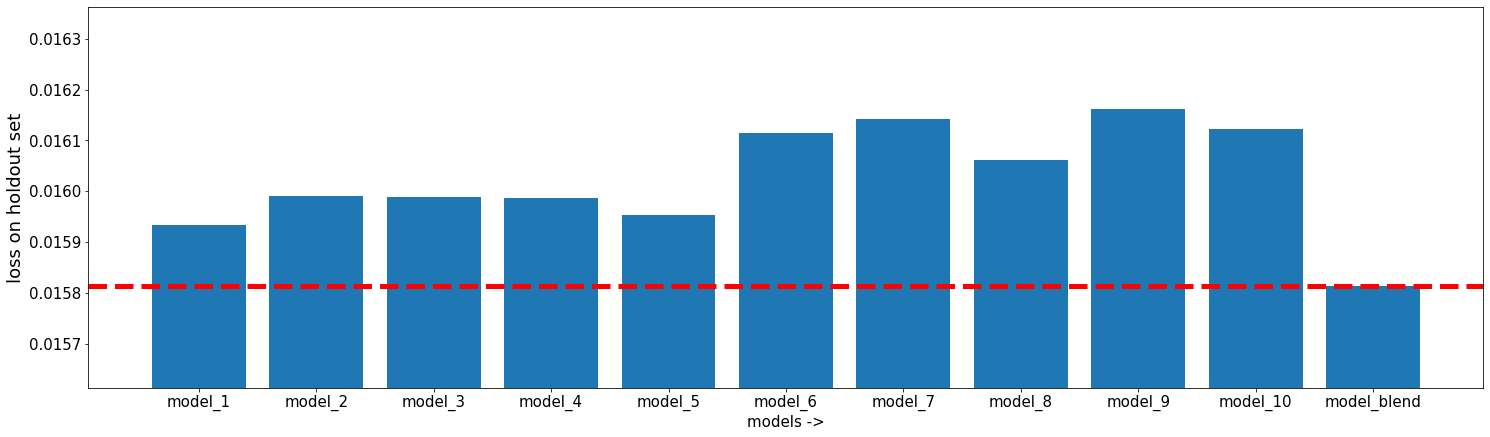

In [64]:
plt.rcParams.update({'font.size': 15})

names = test_val_losses.keys()
vals = test_val_losses.values()

plt.bar(names, vals)
plt.ylim(min(vals)- .0002, max(vals) + 0.0002)
plt.ylabel("loss on holdout set", fontsize = 18)
plt.xlabel("models ->", fontsize = 15)
plt.axhline(y = min(vals), linestyle = "--", c = "r", linewidth = 5)
plt.show()

# Finding good weights, better than the ones made from val losses 

In [65]:
import optuna

In [42]:
def validate_trial( val_loader, criterion, device, params):
    bb = blend(
    weights = np.array(list(params.values())), 
    model_list = model_classes,
    model_filenames = model_filenames
    )
    
    loss_ = validate_fn(bb,val_loader, criterion, device)
    return loss_

In [67]:
def objective(trial):
    params = {
        "w1": trial.suggest_uniform("w1", 0.1, 1.0),
        "w2": trial.suggest_uniform("w2", 0.1, 1.0),
        "w3": trial.suggest_uniform("w3", 0.1, 1.0),
        "w4": trial.suggest_uniform("w4", 0.1, 1.0),
        "w5": trial.suggest_uniform("w5", 0.1, 1.0),
        "w6": trial.suggest_uniform("w6", 0.1, 1.0),
        "w7": trial.suggest_uniform("w7", 0.1, 1.0),
        "w8": trial.suggest_uniform("w8", 0.1, 1.0),
        "w9": trial.suggest_uniform("w9", 0.1, 1.0),
        "w10": trial.suggest_uniform("w10", 0.001, 1.0)

    }
    loss_ = validate_trial(hold_loader,criterion, device, params) 
    return loss_


In [68]:
study = optuna.create_study(direction="minimize")


[I 2020-10-01 08:05:34,933] A new study created in memory with name: no-name-4ec273c3-7585-476d-aa40-072c6bcd8b62


In [69]:
study.optimize(objective, n_trials=800)



[I 2020-10-01 08:05:43,765] Trial 0 finished with value: 0.015844557899981737 and parameters: {'w1': 0.41877197131862964, 'w2': 0.2344127244005913, 'w3': 0.20808826805944003, 'w4': 0.6887625581170844, 'w5': 0.1669251060232107, 'w6': 0.5877326197846178, 'w7': 0.4575739033863523, 'w8': 0.22365712355192835, 'w9': 0.5333304913357263, 'w10': 0.6809551615803193}. Best is trial 0 with value: 0.015844557899981737.
[I 2020-10-01 08:05:43,958] Trial 1 finished with value: 0.015852337703108788 and parameters: {'w1': 0.2299877429787593, 'w2': 0.19826537647483417, 'w3': 0.33575676528368814, 'w4': 0.2848631073780457, 'w5': 0.2566056637605521, 'w6': 0.8555989448242709, 'w7': 0.24186277843093423, 'w8': 0.12558758991243266, 'w9': 0.38859511945627345, 'w10': 0.6703734003179959}. Best is trial 0 with value: 0.015844557899981737.
[I 2020-10-01 08:05:44,151] Trial 2 finished with value: 0.015829571057111025 and parameters: {'w1': 0.8495070006909231, 'w2': 0.13639130159930524, 'w3': 0.4357319946690661, 'w4'

[I 2020-10-01 08:05:48,452] Trial 20 finished with value: 0.015795840648934245 and parameters: {'w1': 0.8989424662619855, 'w2': 0.3473000617173086, 'w3': 0.7248289429879806, 'w4': 0.586466517360955, 'w5': 0.6443829258213801, 'w6': 0.30099629881749534, 'w7': 0.5550371437324433, 'w8': 0.6617165356323911, 'w9': 0.46769942030473477, 'w10': 0.2787205013237999}. Best is trial 17 with value: 0.015790110221132636.
[I 2020-10-01 08:05:48,702] Trial 21 finished with value: 0.01579516171477735 and parameters: {'w1': 0.90538304393443, 'w2': 0.4034715871336096, 'w3': 0.7024181989794639, 'w4': 0.6338013030014653, 'w5': 0.6546116716383964, 'w6': 0.30393994737049596, 'w7': 0.5722974918539698, 'w8': 0.6744972112133641, 'w9': 0.4520933881027526, 'w10': 0.28059748818010477}. Best is trial 17 with value: 0.015790110221132636.
[I 2020-10-01 08:05:48,944] Trial 22 finished with value: 0.015796645311638713 and parameters: {'w1': 0.9105699843034925, 'w2': 0.3260611777254965, 'w3': 0.6995664047096903, 'w4': 0.

[I 2020-10-01 08:05:52,627] Trial 39 finished with value: 0.015807671705260873 and parameters: {'w1': 0.5291413108949461, 'w2': 0.5047757484306554, 'w3': 0.9467522957826581, 'w4': 0.9258134266690479, 'w5': 0.10803852469072048, 'w6': 0.16817172612214157, 'w7': 0.3102361055814867, 'w8': 0.9238321192678394, 'w9': 0.3631806182953414, 'w10': 0.4471951152611442}. Best is trial 17 with value: 0.015790110221132636.
[I 2020-10-01 08:05:52,842] Trial 40 finished with value: 0.01581250224262476 and parameters: {'w1': 0.10153349504472547, 'w2': 0.5790355470970421, 'w3': 0.39813595150862247, 'w4': 0.723772431923505, 'w5': 0.1872957532934601, 'w6': 0.10544958411250561, 'w7': 0.41689240842580383, 'w8': 0.16675585665122694, 'w9': 0.15464969495105804, 'w10': 0.32277786366609407}. Best is trial 17 with value: 0.015790110221132636.
[I 2020-10-01 08:05:53,087] Trial 41 finished with value: 0.015794728649780154 and parameters: {'w1': 0.8383214582204022, 'w2': 0.49347229452988983, 'w3': 0.8659476042739449, 

[I 2020-10-01 08:05:56,969] Trial 58 finished with value: 0.015790813602507114 and parameters: {'w1': 0.9724875695429026, 'w2': 0.2604577296412674, 'w3': 0.9227047925761731, 'w4': 0.966942636839685, 'w5': 0.5008807298185408, 'w6': 0.2781077208302721, 'w7': 0.29101176851504734, 'w8': 0.46472843107796646, 'w9': 0.5751666972790327, 'w10': 0.22150079213567844}. Best is trial 52 with value: 0.01578554743900895.
[I 2020-10-01 08:05:57,300] Trial 59 finished with value: 0.015789227094501257 and parameters: {'w1': 0.924049492014206, 'w2': 0.2772769145277913, 'w3': 0.9112661500215183, 'w4': 0.9554950204053235, 'w5': 0.5817802690332924, 'w6': 0.27510096644360776, 'w7': 0.2991541935139452, 'w8': 0.3844079581049371, 'w9': 0.5935955178902514, 'w10': 0.1755479708494987}. Best is trial 52 with value: 0.01578554743900895.
[I 2020-10-01 08:05:57,597] Trial 60 finished with value: 0.015790696488693357 and parameters: {'w1': 0.9257596964361093, 'w2': 0.2816409347906601, 'w3': 0.9737747013012782, 'w4': 0.

[I 2020-10-01 08:06:01,287] Trial 77 finished with value: 0.015784863382577896 and parameters: {'w1': 0.7157630864821806, 'w2': 0.16929194576015633, 'w3': 0.991838248846604, 'w4': 0.8354772250527176, 'w5': 0.7445842237510357, 'w6': 0.13471042430578373, 'w7': 0.12664466056182716, 'w8': 0.32114621112832004, 'w9': 0.6355370341153308, 'w10': 0.0015664160824400489}. Best is trial 70 with value: 0.015781684778630733.
[I 2020-10-01 08:06:01,497] Trial 78 finished with value: 0.015798468608409166 and parameters: {'w1': 0.8172114344059962, 'w2': 0.16431058537549004, 'w3': 0.18993151792758023, 'w4': 0.870803100389766, 'w5': 0.676269798916467, 'w6': 0.1440963735512655, 'w7': 0.12354463872555128, 'w8': 0.29429317380741893, 'w9': 0.7023044175795574, 'w10': 0.09568008890656879}. Best is trial 70 with value: 0.015781684778630733.
[I 2020-10-01 08:06:01,708] Trial 79 finished with value: 0.015797106316313148 and parameters: {'w1': 0.7629081333405132, 'w2': 0.12667751926783455, 'w3': 0.1214167809370220

[I 2020-10-01 08:06:05,599] Trial 96 finished with value: 0.01577879604883492 and parameters: {'w1': 0.634872949553641, 'w2': 0.10116749425009641, 'w3': 0.8007175194811498, 'w4': 0.7691707147286627, 'w5': 0.8888682854700845, 'w6': 0.25047801060383396, 'w7': 0.1028654214953149, 'w8': 0.15285979491986165, 'w9': 0.3685398935812669, 'w10': 0.12006408753741166}. Best is trial 93 with value: 0.01577685959637165.
[I 2020-10-01 08:06:05,816] Trial 97 finished with value: 0.015779368579387665 and parameters: {'w1': 0.6404861827633341, 'w2': 0.10113682585668174, 'w3': 0.7979556325968442, 'w4': 0.7409486471031548, 'w5': 0.970094685303453, 'w6': 0.24967305245538843, 'w7': 0.1716945148615853, 'w8': 0.1497038748578754, 'w9': 0.37300266432431733, 'w10': 0.13890144601770565}. Best is trial 93 with value: 0.01577685959637165.
[I 2020-10-01 08:06:06,031] Trial 98 finished with value: 0.01577949896454811 and parameters: {'w1': 0.5704200130593352, 'w2': 0.10462490156019857, 'w3': 0.8352377458676653, 'w4':

[I 2020-10-01 08:06:10,508] Trial 115 finished with value: 0.01577630778774619 and parameters: {'w1': 0.7489525754496239, 'w2': 0.16194605216514157, 'w3': 0.8842598840234175, 'w4': 0.6079600126290969, 'w5': 0.933567016279311, 'w6': 0.2036497278005114, 'w7': 0.24645848381650504, 'w8': 0.23935827890682176, 'w9': 0.27691042324392257, 'w10': 0.21226966758452326}. Best is trial 112 with value: 0.01577471219934523.
[I 2020-10-01 08:06:10,726] Trial 116 finished with value: 0.015776514308527112 and parameters: {'w1': 0.7494529460751836, 'w2': 0.15967654856499502, 'w3': 0.882177321133678, 'w4': 0.5369665891395953, 'w5': 0.9321343688450859, 'w6': 0.2332717768304779, 'w7': 0.2471069333609088, 'w8': 0.22708922362031614, 'w9': 0.2632656843893451, 'w10': 0.21021128309389106}. Best is trial 112 with value: 0.01577471219934523.
[I 2020-10-01 08:06:10,939] Trial 117 finished with value: 0.015776342945173383 and parameters: {'w1': 0.7420888530488804, 'w2': 0.15930509438161836, 'w3': 0.9037614856243034,

[I 2020-10-01 08:06:14,928] Trial 134 finished with value: 0.015774552011862397 and parameters: {'w1': 0.8064434489829738, 'w2': 0.30146389303840604, 'w3': 0.9257308695030174, 'w4': 0.4130165989572819, 'w5': 0.9817118276621565, 'w6': 0.11010014646860722, 'w7': 0.39010808836813293, 'w8': 0.2499602295128568, 'w9': 0.23204383636304104, 'w10': 0.19602731174240823}. Best is trial 129 with value: 0.015771313337609172.
[I 2020-10-01 08:06:15,161] Trial 135 finished with value: 0.015773816034197807 and parameters: {'w1': 0.8030839733612898, 'w2': 0.2968254657164919, 'w3': 0.919312412589005, 'w4': 0.4126868381755159, 'w5': 0.9861097890916298, 'w6': 0.1061029231204273, 'w7': 0.28680212367049496, 'w8': 0.25454438182697553, 'w9': 0.2350087683494872, 'w10': 0.2717961567441762}. Best is trial 129 with value: 0.015771313337609172.
[I 2020-10-01 08:06:15,378] Trial 136 finished with value: 0.015774132451042533 and parameters: {'w1': 0.8057765580515871, 'w2': 0.30133803664678377, 'w3': 0.92117961472600

[I 2020-10-01 08:06:19,826] Trial 153 finished with value: 0.015773647697642446 and parameters: {'w1': 0.8433690162737182, 'w2': 0.34711605691795594, 'w3': 0.9433282127585328, 'w4': 0.439563574841072, 'w5': 0.9950779889430184, 'w6': 0.10103690059538105, 'w7': 0.4219801079653467, 'w8': 0.2759430866416572, 'w9': 0.11674545297660277, 'w10': 0.30515126818084637}. Best is trial 129 with value: 0.015771313337609172.
[I 2020-10-01 08:06:20,062] Trial 154 finished with value: 0.015774259343743324 and parameters: {'w1': 0.844033722467883, 'w2': 0.3412978198069144, 'w3': 0.9775601465904187, 'w4': 0.4359761828484035, 'w5': 0.9990728311845349, 'w6': 0.12357284713182141, 'w7': 0.3519435675223979, 'w8': 0.3325114819427278, 'w9': 0.12907080661663034, 'w10': 0.35751966047423395}. Best is trial 129 with value: 0.015771313337609172.
[I 2020-10-01 08:06:20,292] Trial 155 finished with value: 0.01577527984045446 and parameters: {'w1': 0.8478696396032815, 'w2': 0.35160502782922304, 'w3': 0.9787785453326328

[I 2020-10-01 08:06:24,135] Trial 172 finished with value: 0.015771842561662197 and parameters: {'w1': 0.9387159220951566, 'w2': 0.4379915931165382, 'w3': 0.9642039924868467, 'w4': 0.5120974395052303, 'w5': 0.8435408629096781, 'w6': 0.16193749791921377, 'w7': 0.3440058735448542, 'w8': 0.15599400070300007, 'w9': 0.11772909073998829, 'w10': 0.3426836480038665}. Best is trial 167 with value: 0.01577029936015606.
[I 2020-10-01 08:06:24,346] Trial 173 finished with value: 0.015771140344440937 and parameters: {'w1': 0.9348388077469224, 'w2': 0.40588232809213914, 'w3': 0.9986259721322829, 'w4': 0.5214588659255047, 'w5': 0.8256319115662641, 'w6': 0.16677197010980457, 'w7': 0.3010932161998333, 'w8': 0.14080006986211663, 'w9': 0.1161075523076463, 'w10': 0.33673958993689557}. Best is trial 167 with value: 0.01577029936015606.
[I 2020-10-01 08:06:24,600] Trial 174 finished with value: 0.015772072598338127 and parameters: {'w1': 0.9478278373814365, 'w2': 0.42630118606404876, 'w3': 0.999643153638572

[I 2020-10-01 08:06:28,658] Trial 191 finished with value: 0.01577050588093698 and parameters: {'w1': 0.9908234458986951, 'w2': 0.5513396219203671, 'w3': 0.981334924292186, 'w4': 0.508543212302878, 'w5': 0.7795417944074082, 'w6': 0.18138534344106133, 'w7': 0.2644124589658353, 'w8': 0.12341843729244303, 'w9': 0.10027499158464682, 'w10': 0.38618057654493404}. Best is trial 167 with value: 0.01577029936015606.
[I 2020-10-01 08:06:28,917] Trial 192 finished with value: 0.015770618338137865 and parameters: {'w1': 0.9895602990447322, 'w2': 0.545110584956827, 'w3': 0.9798890357964272, 'w4': 0.5111887995081245, 'w5': 0.7760429170027624, 'w6': 0.18342440894185152, 'w7': 0.26666695641574517, 'w8': 0.11439272834860198, 'w9': 0.10246735363255613, 'w10': 0.3862709542042615}. Best is trial 167 with value: 0.01577029936015606.
[I 2020-10-01 08:06:29,135] Trial 193 finished with value: 0.01577046257443726 and parameters: {'w1': 0.9915420120742209, 'w2': 0.5287473750836615, 'w3': 0.9825132367558989, 'w

[I 2020-10-01 08:06:33,242] Trial 210 finished with value: 0.015770991798490286 and parameters: {'w1': 0.9992803402698528, 'w2': 0.5968514735798135, 'w3': 0.9629765574028097, 'w4': 0.5913440021834665, 'w5': 0.6735656668014581, 'w6': 0.19312488877073908, 'w7': 0.22792188882181927, 'w8': 0.10191297414449584, 'w9': 0.10456875600491705, 'w10': 0.40658722212638093}. Best is trial 199 with value: 0.015769939171150327.
[I 2020-10-01 08:06:33,460] Trial 211 finished with value: 0.015770940110087395 and parameters: {'w1': 0.9929586850183428, 'w2': 0.5985039688380661, 'w3': 0.9638395414674241, 'w4': 0.6019505436919962, 'w5': 0.6688944992187551, 'w6': 0.19132318979340712, 'w7': 0.22679180693178855, 'w8': 0.10082571771780845, 'w9': 0.10343207198782682, 'w10': 0.4030194577761798}. Best is trial 199 with value: 0.015769939171150327.
[I 2020-10-01 08:06:33,683] Trial 212 finished with value: 0.015771454432979226 and parameters: {'w1': 0.9984055390592109, 'w2': 0.6020365237552215, 'w3': 0.960397379636

[I 2020-10-01 08:06:37,702] Trial 229 finished with value: 0.01577073405496776 and parameters: {'w1': 0.9653150949439834, 'w2': 0.5690916503271473, 'w3': 0.981393486003984, 'w4': 0.5710419064381387, 'w5': 0.669015252307121, 'w6': 0.1876843289160308, 'w7': 0.1950632901602148, 'w8': 0.1029715717566104, 'w9': 0.1448033038879832, 'w10': 0.353735311330697}. Best is trial 219 with value: 0.015769770136103034.
[I 2020-10-01 08:06:37,921] Trial 230 finished with value: 0.01577148400247097 and parameters: {'w1': 0.9653710635708705, 'w2': 0.5883988177947714, 'w3': 0.9880814558952591, 'w4': 0.5771630205646507, 'w5': 0.7185975261036119, 'w6': 0.20668004955077823, 'w7': 0.19456249219154942, 'w8': 0.12336456144005528, 'w9': 0.15017371981484684, 'w10': 0.4053636279297969}. Best is trial 219 with value: 0.015769770136103034.
[I 2020-10-01 08:06:38,142] Trial 231 finished with value: 0.01577033498324454 and parameters: {'w1': 0.9813527416063497, 'w2': 0.5619884109670961, 'w3': 0.9786928841520477, 'w4':

[I 2020-10-01 08:06:42,494] Trial 248 finished with value: 0.01577054476365447 and parameters: {'w1': 0.9570308988554834, 'w2': 0.5846938006927201, 'w3': 0.9968795029889739, 'w4': 0.555907651095996, 'w5': 0.7251882263148297, 'w6': 0.24906700121240247, 'w7': 0.16598241214270035, 'w8': 0.13891112243647388, 'w9': 0.14536450263643177, 'w10': 0.32477290797431385}. Best is trial 241 with value: 0.015769181307405233.
[I 2020-10-01 08:06:42,715] Trial 249 finished with value: 0.015771302627399564 and parameters: {'w1': 0.9576661382685556, 'w2': 0.6103487499451887, 'w3': 0.9988492497078826, 'w4': 0.5375495207435892, 'w5': 0.7230247312686411, 'w6': 0.2693462158220127, 'w7': 0.1730243371951051, 'w8': 0.12727918186955273, 'w9': 0.1618373741614043, 'w10': 0.32380607642888115}. Best is trial 241 with value: 0.015769181307405233.
[I 2020-10-01 08:06:42,931] Trial 250 finished with value: 0.015770377591252327 and parameters: {'w1': 0.9155176759893441, 'w2': 0.6391352571918006, 'w3': 0.9965052039371033

[I 2020-10-01 08:06:46,959] Trial 267 finished with value: 0.015770734986290336 and parameters: {'w1': 0.9243888678664312, 'w2': 0.6642686085841242, 'w3': 0.9402317943287958, 'w4': 0.6545326095815633, 'w5': 0.7114393164717489, 'w6': 0.28147665086323165, 'w7': 0.11689480875884779, 'w8': 0.18919224981956195, 'w9': 0.1692540147661005, 'w10': 0.2821554146511087}. Best is trial 260 with value: 0.01576882624067366.
[I 2020-10-01 08:06:47,188] Trial 268 finished with value: 0.015770455356687307 and parameters: {'w1': 0.9266427334820863, 'w2': 0.7884948025858751, 'w3': 0.9330009041185743, 'w4': 0.6364062732849309, 'w5': 0.7312416049989854, 'w6': 0.27780393119677915, 'w7': 0.13237934164059884, 'w8': 0.14651910296794768, 'w9': 0.1578562547020138, 'w10': 0.2917215263730567}. Best is trial 260 with value: 0.01576882624067366.
[I 2020-10-01 08:06:47,453] Trial 269 finished with value: 0.01576904417015612 and parameters: {'w1': 0.9479032755107583, 'w2': 0.7291746762076037, 'w3': 0.9366519678532078, 

[I 2020-10-01 08:06:51,695] Trial 286 finished with value: 0.015770056284964085 and parameters: {'w1': 0.9386913216668636, 'w2': 0.6919658303982922, 'w3': 0.8958446174493093, 'w4': 0.6787426760481635, 'w5': 0.686356088088261, 'w6': 0.22689368329311418, 'w7': 0.10063029828368594, 'w8': 0.1954293427859133, 'w9': 0.20460755204142095, 'w10': 0.241397065098721}. Best is trial 272 with value: 0.015768688870593905.
[I 2020-10-01 08:06:51,985] Trial 287 finished with value: 0.015769400633871555 and parameters: {'w1': 0.9432690473537083, 'w2': 0.7107259069368449, 'w3': 0.8964707310052555, 'w4': 0.7049466845675081, 'w5': 0.6971793263336269, 'w6': 0.22525414804347163, 'w7': 0.10082715749922877, 'w8': 0.19356269280345617, 'w9': 0.18142257194175704, 'w10': 0.2411731690627379}. Best is trial 272 with value: 0.015768688870593905.
[I 2020-10-01 08:06:52,324] Trial 288 finished with value: 0.015770009951665998 and parameters: {'w1': 0.8968322912112499, 'w2': 0.7210526656624451, 'w3': 0.892196941381507,

[I 2020-10-01 08:06:56,511] Trial 305 finished with value: 0.015769464895129204 and parameters: {'w1': 0.957140849268807, 'w2': 0.6591973814250044, 'w3': 0.9017722112758486, 'w4': 0.6877997512471645, 'w5': 0.7475198592031054, 'w6': 0.2604896503608913, 'w7': 0.12111379480469132, 'w8': 0.16744366867042085, 'w9': 0.16092691116305702, 'w10': 0.2737891344852584}. Best is trial 304 with value: 0.01576849538832903.
[I 2020-10-01 08:06:56,774] Trial 306 finished with value: 0.01576937106437981 and parameters: {'w1': 0.9569913038052539, 'w2': 0.6602068325984783, 'w3': 0.9020068412795569, 'w4': 0.6596031583038885, 'w5': 0.7481386280370725, 'w6': 0.2507857708163803, 'w7': 0.13967918120613632, 'w8': 0.1681631222900505, 'w9': 0.15164432519968005, 'w10': 0.27224018806064104}. Best is trial 304 with value: 0.01576849538832903.
[I 2020-10-01 08:06:57,035] Trial 307 finished with value: 0.015770369675010443 and parameters: {'w1': 0.9544602470568505, 'w2': 0.7641336885652737, 'w3': 0.8996243880773568, '

[I 2020-10-01 08:07:01,474] Trial 324 finished with value: 0.015774606494233012 and parameters: {'w1': 0.49743995480824876, 'w2': 0.651696647587526, 'w3': 0.9024201477688841, 'w4': 0.6283752484600145, 'w5': 0.7855406701870257, 'w6': 0.24434612073366152, 'w7': 0.12789101328147187, 'w8': 0.1872921632113773, 'w9': 0.14734691296652458, 'w10': 0.2853717649239522}. Best is trial 304 with value: 0.01576849538832903.
[I 2020-10-01 08:07:01,701] Trial 325 finished with value: 0.015769098652526736 and parameters: {'w1': 0.9710412827893297, 'w2': 0.6702180013716349, 'w3': 0.8776335899151254, 'w4': 0.6934399463176375, 'w5': 0.7419349408943134, 'w6': 0.26694145224079185, 'w7': 0.11542659389253006, 'w8': 0.16794096092333732, 'w9': 0.16712967687136654, 'w10': 0.23150362933772484}. Best is trial 304 with value: 0.01576849538832903.
[I 2020-10-01 08:07:01,927] Trial 326 finished with value: 0.015769827412441373 and parameters: {'w1': 0.9718587427136052, 'w2': 0.6713227675950704, 'w3': 0.873677515067965

[I 2020-10-01 08:07:06,170] Trial 343 finished with value: 0.015768742421641946 and parameters: {'w1': 0.9032127679033296, 'w2': 0.6509188023376592, 'w3': 0.8647141687498279, 'w4': 0.6353577967269538, 'w5': 0.796053041581006, 'w6': 0.20793748266639625, 'w7': 0.12035192181796153, 'w8': 0.17887268326451197, 'w9': 0.15392396784398515, 'w10': 0.2954208160874351}. Best is trial 304 with value: 0.01576849538832903.
[I 2020-10-01 08:07:06,433] Trial 344 finished with value: 0.01577706797979772 and parameters: {'w1': 0.8976317981832116, 'w2': 0.6544178482050748, 'w3': 0.841956924272678, 'w4': 0.6368790141414684, 'w5': 0.7970071514006518, 'w6': 0.624653578480255, 'w7': 0.1197336753668849, 'w8': 0.19426996775880037, 'w9': 0.15821196675992033, 'w10': 0.2918852183077908}. Best is trial 304 with value: 0.01576849538832903.
[I 2020-10-01 08:07:06,962] Trial 345 finished with value: 0.015767861856147647 and parameters: {'w1': 0.9158843423553548, 'w2': 0.6334021642324813, 'w3': 0.8541519153339917, 'w4

[I 2020-10-01 08:07:11,518] Trial 362 finished with value: 0.015766384080052376 and parameters: {'w1': 0.8661306941401792, 'w2': 0.6388975183343224, 'w3': 0.8129797109013548, 'w4': 0.6067153083249993, 'w5': 0.8714499463914651, 'w6': 0.2007808903089328, 'w7': 0.13257104400536154, 'w8': 0.24410591321374434, 'w9': 0.12211480795838309, 'w10': 0.15167710606642032}. Best is trial 360 with value: 0.01576633518561721.
[I 2020-10-01 08:07:11,751] Trial 363 finished with value: 0.015766744036227465 and parameters: {'w1': 0.8647502363392857, 'w2': 0.6226966972605761, 'w3': 0.7792099904686282, 'w4': 0.6052341288252188, 'w5': 0.879671718991149, 'w6': 0.20395553569812866, 'w7': 0.13565500762029792, 'w8': 0.26034560538625384, 'w9': 0.12567499334393475, 'w10': 0.15881029666345037}. Best is trial 360 with value: 0.01576633518561721.
[I 2020-10-01 08:07:12,009] Trial 364 finished with value: 0.01576661947183311 and parameters: {'w1': 0.8713110336710014, 'w2': 0.6178011224774802, 'w3': 0.7680545034502122

[I 2020-10-01 08:07:16,525] Trial 381 finished with value: 0.01576652331277728 and parameters: {'w1': 0.8552947649423421, 'w2': 0.612969268156709, 'w3': 0.7418670436694428, 'w4': 0.5918959886354075, 'w5': 0.8828798138369915, 'w6': 0.1491944465127506, 'w7': 0.19002210499930297, 'w8': 0.2634051405109407, 'w9': 0.1152742930244419, 'w10': 0.14151226846806345}. Best is trial 379 with value: 0.01576627604663372.
[I 2020-10-01 08:07:16,822] Trial 382 finished with value: 0.015766340773552656 and parameters: {'w1': 0.8513872695449761, 'w2': 0.6145202564341475, 'w3': 0.7370275418820339, 'w4': 0.5945980374056357, 'w5': 0.884722614558108, 'w6': 0.1530071257703884, 'w7': 0.1698960150868879, 'w8': 0.26915226399842135, 'w9': 0.11806731600073878, 'w10': 0.14252187286010007}. Best is trial 379 with value: 0.01576627604663372.
[I 2020-10-01 08:07:17,073] Trial 383 finished with value: 0.015766408061608672 and parameters: {'w1': 0.8469755296952345, 'w2': 0.608521818476557, 'w3': 0.7283411226638553, 'w4'

[I 2020-10-01 08:07:21,290] Trial 400 finished with value: 0.015766146359965205 and parameters: {'w1': 0.8286247017398448, 'w2': 0.5840741037703576, 'w3': 0.7004146020147716, 'w4': 0.5835156986822347, 'w5': 0.9071657937804231, 'w6': 0.13532305882869877, 'w7': 0.20037185776028452, 'w8': 0.2965475557546264, 'w9': 0.10652221823060343, 'w10': 0.10103063184970051}. Best is trial 397 with value: 0.01576601737178862.
[I 2020-10-01 08:07:21,522] Trial 401 finished with value: 0.015765658812597394 and parameters: {'w1': 0.8374958506689634, 'w2': 0.5802269920814428, 'w3': 0.6944095739477695, 'w4': 0.5828038204438858, 'w5': 0.9194145197709669, 'w6': 0.1309087888860098, 'w7': 0.20515877011821484, 'w8': 0.31985019906203016, 'w9': 0.10105253686565822, 'w10': 0.06691108285542008}. Best is trial 401 with value: 0.015765658812597394.
[I 2020-10-01 08:07:21,757] Trial 402 finished with value: 0.01576575660146773 and parameters: {'w1': 0.8305285704084481, 'w2': 0.5813814908456185, 'w3': 0.690911024256320

[I 2020-10-01 08:07:26,166] Trial 419 finished with value: 0.015765434131026268 and parameters: {'w1': 0.8101847466755772, 'w2': 0.567639145977349, 'w3': 0.6415336624951051, 'w4': 0.5647562598930701, 'w5': 0.9468143827300405, 'w6': 0.11916055073674425, 'w7': 0.20857250767548635, 'w8': 0.3174046323140712, 'w9': 0.10016488085726134, 'w10': 0.045529219745676815}. Best is trial 418 with value: 0.01576538383960724.
[I 2020-10-01 08:07:26,402] Trial 420 finished with value: 0.01576538081280887 and parameters: {'w1': 0.8110183950871264, 'w2': 0.5652357438445722, 'w3': 0.6647423706927386, 'w4': 0.5670082079319607, 'w5': 0.9467888531950581, 'w6': 0.11608658836121347, 'w7': 0.2096664124775733, 'w8': 0.31842442293306267, 'w9': 0.10295074509612936, 'w10': 0.042957050220244056}. Best is trial 420 with value: 0.01576538081280887.
[I 2020-10-01 08:07:26,637] Trial 421 finished with value: 0.015765724005177617 and parameters: {'w1': 0.804834696735287, 'w2': 0.567310197599256, 'w3': 0.6476403845464047,

[I 2020-10-01 08:07:30,979] Trial 438 finished with value: 0.015765691874548793 and parameters: {'w1': 0.7592589885190364, 'w2': 0.5545812075762593, 'w3': 0.6068890841239756, 'w4': 0.5315428804523747, 'w5': 0.9436865952612888, 'w6': 0.10469561361757812, 'w7': 0.21849373287084523, 'w8': 0.33640562206051594, 'w9': 0.10128772408821612, 'w10': 0.008620708974320768}. Best is trial 430 with value: 0.01576530607417226.
[I 2020-10-01 08:07:31,222] Trial 439 finished with value: 0.01576574263162911 and parameters: {'w1': 0.7543976514987264, 'w2': 0.5509463608316751, 'w3': 0.6188942388280233, 'w4': 0.5278640110938712, 'w5': 0.9477892162718274, 'w6': 0.10355072292610161, 'w7': 0.22355452287408142, 'w8': 0.3420411537546215, 'w9': 0.10066727786194479, 'w10': 0.0027691489176950718}. Best is trial 430 with value: 0.01576530607417226.
[I 2020-10-01 08:07:31,458] Trial 440 finished with value: 0.0157664290163666 and parameters: {'w1': 0.7573502931291618, 'w2': 0.5514421343679512, 'w3': 0.59925913355486

[I 2020-10-01 08:07:35,731] Trial 457 finished with value: 0.015765326097607613 and parameters: {'w1': 0.7869589772996842, 'w2': 0.5375520503516749, 'w3': 0.6241781758191707, 'w4': 0.5328774616313123, 'w5': 0.9555035897244704, 'w6': 0.11767796941900888, 'w7': 0.22170390410732282, 'w8': 0.3163859416574085, 'w9': 0.10047369142404687, 'w10': 0.0027852850780090365}. Best is trial 452 with value: 0.01576500223018229.
[I 2020-10-01 08:07:36,010] Trial 458 finished with value: 0.015766352647915483 and parameters: {'w1': 0.7493480035831087, 'w2': 0.5343939267824536, 'w3': 0.5654352160008185, 'w4': 0.5216460913246951, 'w5': 0.9970878778531328, 'w6': 0.1206650576859308, 'w7': 0.24190903277145437, 'w8': 0.31779111420822403, 'w9': 0.10076779441984712, 'w10': 0.0053562640807129835}. Best is trial 452 with value: 0.01576500223018229.
[I 2020-10-01 08:07:36,342] Trial 459 finished with value: 0.01576582039706409 and parameters: {'w1': 0.7765219650706955, 'w2': 0.5303894513231898, 'w3': 0.595153571005

[I 2020-10-01 08:07:40,659] Trial 476 finished with value: 0.01576728420332074 and parameters: {'w1': 0.8151434933765788, 'w2': 0.542657425118122, 'w3': 0.6779624543815094, 'w4': 0.5455165964371166, 'w5': 0.9980236898193628, 'w6': 0.12713936194514083, 'w7': 0.2052883424298343, 'w8': 0.5253958150416231, 'w9': 0.10000982018919592, 'w10': 0.04736023517981984}. Best is trial 452 with value: 0.01576500223018229.
[I 2020-10-01 08:07:40,899] Trial 477 finished with value: 0.01578705571591854 and parameters: {'w1': 0.7873100289078645, 'w2': 0.5210026152261316, 'w3': 0.6477846207640562, 'w4': 0.5183818584535805, 'w5': 0.9589993932479831, 'w6': 0.11615662479784786, 'w7': 0.23324677034775657, 'w8': 0.3550064427238935, 'w9': 0.8167053942656708, 'w10': 0.0742663485519328}. Best is trial 452 with value: 0.01576500223018229.
[I 2020-10-01 08:07:41,156] Trial 478 finished with value: 0.015766863245517015 and parameters: {'w1': 0.7734184310510434, 'w2': 0.5652554757080955, 'w3': 0.6280104796023048, 'w4

[I 2020-10-01 08:07:45,586] Trial 495 finished with value: 0.01576471095904708 and parameters: {'w1': 0.8019419090424103, 'w2': 0.5470234516404411, 'w3': 0.6598367912290636, 'w4': 0.5669908539347294, 'w5': 0.9437730924605195, 'w6': 0.11520502559012484, 'w7': 0.1799273384048916, 'w8': 0.30182216949457663, 'w9': 0.10013268455481572, 'w10': 0.04773428163578472}. Best is trial 482 with value: 0.01576432748697698.
[I 2020-10-01 08:07:45,829] Trial 496 finished with value: 0.015765226678922772 and parameters: {'w1': 0.796115121638371, 'w2': 0.5073192597084877, 'w3': 0.6513308954277557, 'w4': 0.5469721075321635, 'w5': 0.9959057598705473, 'w6': 0.11402299851947638, 'w7': 0.17815042651059765, 'w8': 0.29689921407703973, 'w9': 0.13411366750704942, 'w10': 0.041706490238442404}. Best is trial 482 with value: 0.01576432748697698.
[I 2020-10-01 08:07:46,066] Trial 497 finished with value: 0.015765101416036487 and parameters: {'w1': 0.800117550968335, 'w2': 0.5098795779664713, 'w3': 0.6559022292361155

[I 2020-10-01 08:07:50,480] Trial 514 finished with value: 0.015765651362016797 and parameters: {'w1': 0.7875560957724008, 'w2': 0.47747806494871076, 'w3': 0.6868986176872632, 'w4': 0.528840818717749, 'w5': 0.9993593470259233, 'w6': 0.1392214613195611, 'w7': 0.17365856742740948, 'w8': 0.29653752140191436, 'w9': 0.15780434617379363, 'w10': 0.0043802173153055825}. Best is trial 482 with value: 0.01576432748697698.
[I 2020-10-01 08:07:50,766] Trial 515 finished with value: 0.01576710375957191 and parameters: {'w1': 0.7930646193534192, 'w2': 0.4716015821011461, 'w3': 0.7044229005100155, 'w4': 0.5403312212139135, 'w5': 0.9996767938889491, 'w6': 0.13936105242088107, 'w7': 0.1699533784256619, 'w8': 0.4553829119840812, 'w9': 0.14203961836613113, 'w10': 0.03729735694615203}. Best is trial 482 with value: 0.01576432748697698.
[I 2020-10-01 08:07:51,027] Trial 516 finished with value: 0.01576489326544106 and parameters: {'w1': 0.8001501362552825, 'w2': 0.4818132525443361, 'w3': 0.6810880413647761

[I 2020-10-01 08:07:55,232] Trial 533 finished with value: 0.015764798503369093 and parameters: {'w1': 0.8418931420073601, 'w2': 0.44725131858349065, 'w3': 0.7101919279665075, 'w4': 0.4621814111528991, 'w5': 0.9840537806335286, 'w6': 0.1024662209666873, 'w7': 0.15354648721720973, 'w8': 0.27672686366212573, 'w9': 0.1846676035605056, 'w10': 0.008563078859920602}. Best is trial 520 with value: 0.015763937029987574.
[I 2020-10-01 08:07:55,478] Trial 534 finished with value: 0.015765803400427103 and parameters: {'w1': 0.8495495628416749, 'w2': 0.4451945053506292, 'w3': 0.7083736503646888, 'w4': 0.4458033637316234, 'w5': 0.9993520735706395, 'w6': 0.1011483909433974, 'w7': 0.16219508499001553, 'w8': 0.27310463347488406, 'w9': 0.22691867657293513, 'w10': 0.004120047954275499}. Best is trial 520 with value: 0.015763937029987574.
[I 2020-10-01 08:07:55,716] Trial 535 finished with value: 0.015765690710395575 and parameters: {'w1': 0.8452369937910071, 'w2': 0.4672424816418818, 'w3': 0.70141455847

[I 2020-10-01 08:08:00,242] Trial 552 finished with value: 0.015764800598844886 and parameters: {'w1': 0.848194745322502, 'w2': 0.46435467635830396, 'w3': 0.7539191322291442, 'w4': 0.4273238813383782, 'w5': 0.9995630943479634, 'w6': 0.10243140895072897, 'w7': 0.1497855073428961, 'w8': 0.2738874377205552, 'w9': 0.1872428224771527, 'w10': 0.018609326523994926}. Best is trial 520 with value: 0.015763937029987574.
[I 2020-10-01 08:08:00,522] Trial 553 finished with value: 0.015765205956995487 and parameters: {'w1': 0.8542676010492013, 'w2': 0.4747939314661183, 'w3': 0.7370052187934806, 'w4': 0.41359704246660156, 'w5': 0.9990636219883323, 'w6': 0.12593248304570012, 'w7': 0.14380809657641158, 'w8': 0.2988780653284108, 'w9': 0.18646800272696523, 'w10': 0.018652160543602612}. Best is trial 520 with value: 0.015763937029987574.
[I 2020-10-01 08:08:00,805] Trial 554 finished with value: 0.01577240345068276 and parameters: {'w1': 0.8303045105462128, 'w2': 0.46855468181252946, 'w3': 0.750949948977

[I 2020-10-01 08:08:05,184] Trial 571 finished with value: 0.015764989890158176 and parameters: {'w1': 0.8901939446329287, 'w2': 0.4350644822661032, 'w3': 0.7492084823273978, 'w4': 0.35461308722260676, 'w5': 0.9676272584021269, 'w6': 0.12343793151788554, 'w7': 0.13746787951834938, 'w8': 0.285062029071744, 'w9': 0.18082103447294814, 'w10': 0.02627618373037441}. Best is trial 520 with value: 0.015763937029987574.
[I 2020-10-01 08:08:05,425] Trial 572 finished with value: 0.015765358693897724 and parameters: {'w1': 0.8845124905039636, 'w2': 0.41455529766091487, 'w3': 0.7917137588101458, 'w4': 0.4350048852432803, 'w5': 0.9999031820158285, 'w6': 0.12411344298670077, 'w7': 0.1607701167951284, 'w8': 0.25925486704623985, 'w9': 0.19264708872023445, 'w10': 0.03045339555404332}. Best is trial 520 with value: 0.015763937029987574.
[I 2020-10-01 08:08:05,668] Trial 573 finished with value: 0.015764416893944144 and parameters: {'w1': 0.8638747218807526, 'w2': 0.4622304929791222, 'w3': 0.721952891408

[I 2020-10-01 08:08:10,488] Trial 590 finished with value: 0.015764918411150575 and parameters: {'w1': 0.885022632704629, 'w2': 0.48939578102132414, 'w3': 0.739968716598399, 'w4': 0.4876433510534847, 'w5': 0.9636668136295677, 'w6': 0.15965662530557437, 'w7': 0.1273005550166546, 'w8': 0.2465422459253259, 'w9': 0.1729207208260838, 'w10': 0.04997052890530998}. Best is trial 587 with value: 0.015763229224830866.
[I 2020-10-01 08:08:10,733] Trial 591 finished with value: 0.01576453377492726 and parameters: {'w1': 0.9008046153512835, 'w2': 0.5019395691080895, 'w3': 0.7652442252175493, 'w4': 0.4878254033482107, 'w5': 0.9631343365241742, 'w6': 0.14476164787022963, 'w7': 0.13091068080887977, 'w8': 0.2226520870038364, 'w9': 0.173198130568613, 'w10': 0.05733257549905161}. Best is trial 587 with value: 0.015763229224830866.
[I 2020-10-01 08:08:10,977] Trial 592 finished with value: 0.01576464925892651 and parameters: {'w1': 0.9007998601249552, 'w2': 0.5063672593178243, 'w3': 0.794795232020546, 'w4

[I 2020-10-01 08:08:15,557] Trial 609 finished with value: 0.015764905838295817 and parameters: {'w1': 0.8951471099177226, 'w2': 0.48547444630769254, 'w3': 0.7990054892176924, 'w4': 0.5011554548955234, 'w5': 0.934436804619255, 'w6': 0.17386597198278836, 'w7': 0.11150706658198412, 'w8': 0.20949194581900982, 'w9': 0.16263747428940237, 'w10': 0.08655098015898587}. Best is trial 587 with value: 0.015763229224830866.
[I 2020-10-01 08:08:15,810] Trial 610 finished with value: 0.015765927033498883 and parameters: {'w1': 0.9152844054616093, 'w2': 0.5163819174583574, 'w3': 0.7853175468566788, 'w4': 0.2770193237733708, 'w5': 0.9534171978826586, 'w6': 0.17043515311589663, 'w7': 0.10032455866604917, 'w8': 0.21284856868621502, 'w9': 0.2089591139588676, 'w10': 0.07472511244670464}. Best is trial 587 with value: 0.015763229224830866.
[I 2020-10-01 08:08:16,091] Trial 611 finished with value: 0.015764439711347222 and parameters: {'w1': 0.8940092164740115, 'w2': 0.4930978628740865, 'w3': 0.783577596251

[I 2020-10-01 08:08:20,670] Trial 628 finished with value: 0.015765039017423987 and parameters: {'w1': 0.9223733508537727, 'w2': 0.5079351843107168, 'w3': 0.7741544911287052, 'w4': 0.4478391825748138, 'w5': 0.9160725945254778, 'w6': 0.1776023346958381, 'w7': 0.10104694026115127, 'w8': 0.20448351676329102, 'w9': 0.1608592505874215, 'w10': 0.11830506563746411}. Best is trial 587 with value: 0.015763229224830866.
[I 2020-10-01 08:08:20,946] Trial 629 finished with value: 0.015764828072860837 and parameters: {'w1': 0.8903237275355643, 'w2': 0.49352575665791926, 'w3': 0.8112307286367443, 'w4': 0.48354791360107824, 'w5': 0.9449682654107596, 'w6': 0.15005293579258877, 'w7': 0.10038458925364013, 'w8': 0.2275557236199629, 'w9': 0.17997582132358594, 'w10': 0.0877794734772544}. Best is trial 587 with value: 0.015763229224830866.
[I 2020-10-01 08:08:21,255] Trial 630 finished with value: 0.01576448418200016 and parameters: {'w1': 0.9083249956988205, 'w2': 0.5174038757347101, 'w3': 0.82898742092053

[I 2020-10-01 08:08:25,830] Trial 647 finished with value: 0.015764850424602628 and parameters: {'w1': 0.8842811911477249, 'w2': 0.46699834527393425, 'w3': 0.8285325257533623, 'w4': 0.46393128447259313, 'w5': 0.9434231878757654, 'w6': 0.1546577577059793, 'w7': 0.10260452636058995, 'w8': 0.23871022608966516, 'w9': 0.17711377386113714, 'w10': 0.06728763403224243}. Best is trial 587 with value: 0.015763229224830866.
[I 2020-10-01 08:08:26,082] Trial 648 finished with value: 0.01576481363736093 and parameters: {'w1': 0.9292869888631632, 'w2': 0.5072381262602547, 'w3': 0.8579615339256211, 'w4': 0.44045840144621046, 'w5': 0.9288950861349985, 'w6': 0.14591104840103103, 'w7': 0.11893916445840584, 'w8': 0.22015040206564568, 'w9': 0.1563609406235526, 'w10': 0.12118476840646542}. Best is trial 587 with value: 0.015763229224830866.
[I 2020-10-01 08:08:26,327] Trial 649 finished with value: 0.01576459314674139 and parameters: {'w1': 0.8851984720685592, 'w2': 0.49596563637327784, 'w3': 0.80647058543

[I 2020-10-01 08:08:30,833] Trial 666 finished with value: 0.015764256473630667 and parameters: {'w1': 0.9311912723707554, 'w2': 0.461612386311707, 'w3': 0.8428603116033516, 'w4': 0.4024490218154747, 'w5': 0.9097271486717045, 'w6': 0.14221723064593073, 'w7': 0.10110150478940652, 'w8': 0.1927111334539794, 'w9': 0.14673401955122184, 'w10': 0.11713655994971485}. Best is trial 587 with value: 0.015763229224830866.
[I 2020-10-01 08:08:31,118] Trial 667 finished with value: 0.015764407813549042 and parameters: {'w1': 0.9371261461966891, 'w2': 0.4504122300502207, 'w3': 0.8603557239784051, 'w4': 0.3781130129635094, 'w5': 0.9042482889428274, 'w6': 0.14074661240729244, 'w7': 0.10212556257694524, 'w8': 0.1906056085351418, 'w9': 0.1399326020556542, 'w10': 0.13115457170423692}. Best is trial 587 with value: 0.015763229224830866.
[I 2020-10-01 08:08:31,463] Trial 668 finished with value: 0.01576473005115986 and parameters: {'w1': 0.9348952001905966, 'w2': 0.44610608122307877, 'w3': 0.866634185389410

[I 2020-10-01 08:08:36,264] Trial 685 finished with value: 0.015774819301441312 and parameters: {'w1': 0.9166895878592605, 'w2': 0.4476431314191578, 'w3': 0.8572980169944716, 'w4': 0.4144668520885081, 'w5': 0.9165699144809181, 'w6': 0.18191326302950833, 'w7': 0.5646043259791592, 'w8': 0.19094270916318817, 'w9': 0.13629657388949468, 'w10': 0.13128094531311027}. Best is trial 587 with value: 0.015763229224830866.
[I 2020-10-01 08:08:36,516] Trial 686 finished with value: 0.01576644997112453 and parameters: {'w1': 0.9315162831933472, 'w2': 0.48413063870507644, 'w3': 0.8372780867982844, 'w4': 0.4317392254165836, 'w5': 0.8549743123249157, 'w6': 0.15889864773264545, 'w7': 0.10239306973849625, 'w8': 0.2117879817213518, 'w9': 0.1862781939701385, 'w10': 0.17150119921457346}. Best is trial 587 with value: 0.015763229224830866.
[I 2020-10-01 08:08:36,773] Trial 687 finished with value: 0.015764532145112753 and parameters: {'w1': 0.904241749795049, 'w2': 0.4639017728014618, 'w3': 0.869076753335769

[I 2020-10-01 08:08:41,260] Trial 704 finished with value: 0.015764100709930062 and parameters: {'w1': 0.9626016011572, 'w2': 0.3835183226407416, 'w3': 0.8809167881787981, 'w4': 0.3692794245727943, 'w5': 0.8887058683928847, 'w6': 0.12905250408143887, 'w7': 0.1346834430612099, 'w8': 0.15258255408775914, 'w9': 0.12920072981569988, 'w10': 0.09341859459599104}. Best is trial 587 with value: 0.015763229224830866.
[I 2020-10-01 08:08:41,511] Trial 705 finished with value: 0.01576406415551901 and parameters: {'w1': 0.9722477456120858, 'w2': 0.3937030000036655, 'w3': 0.8768973056244728, 'w4': 0.33692638759805477, 'w5': 0.8826526992724911, 'w6': 0.12753376105650768, 'w7': 0.13277819549157757, 'w8': 0.15341091268238327, 'w9': 0.12820103382305204, 'w10': 0.09132781819993753}. Best is trial 587 with value: 0.015763229224830866.
[I 2020-10-01 08:08:41,764] Trial 706 finished with value: 0.015764456940814853 and parameters: {'w1': 0.9837941687615097, 'w2': 0.3585121984047138, 'w3': 0.884352295221820

[I 2020-10-01 08:08:46,328] Trial 723 finished with value: 0.01576870889402926 and parameters: {'w1': 0.9436199237998963, 'w2': 0.3945837314383338, 'w3': 0.8653186295839441, 'w4': 0.34770312995916375, 'w5': 0.8890507563808379, 'w6': 0.3605143000590195, 'w7': 0.13482753893690325, 'w8': 0.17119976511847074, 'w9': 0.12514958735249837, 'w10': 0.08778256584457161}. Best is trial 587 with value: 0.015763229224830866.
[I 2020-10-01 08:08:46,587] Trial 724 finished with value: 0.015764399198815227 and parameters: {'w1': 0.9675137057739824, 'w2': 0.42525173662589566, 'w3': 0.8821967892044846, 'w4': 0.38597997478895296, 'w5': 0.9021435239629774, 'w6': 0.15270854309060788, 'w7': 0.11778710182189205, 'w8': 0.1377305290689112, 'w9': 0.1437904595234815, 'w10': 0.11490417025556275}. Best is trial 587 with value: 0.015763229224830866.
[I 2020-10-01 08:08:46,847] Trial 725 finished with value: 0.01576423761434853 and parameters: {'w1': 0.9868699918261402, 'w2': 0.3421722036448782, 'w3': 0.8981239227960

[I 2020-10-01 08:08:51,574] Trial 742 finished with value: 0.015763717936351895 and parameters: {'w1': 0.9999482288691394, 'w2': 0.32368039153306316, 'w3': 0.908146244181141, 'w4': 0.34900666947960574, 'w5': 0.8224204523294967, 'w6': 0.11947310201329701, 'w7': 0.11871039121648327, 'w8': 0.13837225852485532, 'w9': 0.11744226124849838, 'w10': 0.05179044111163555}. Best is trial 587 with value: 0.015763229224830866.
[I 2020-10-01 08:08:51,835] Trial 743 finished with value: 0.015764152398332953 and parameters: {'w1': 0.998121145553137, 'w2': 0.30224400682623015, 'w3': 0.9087457213599164, 'w4': 0.3011272106742929, 'w5': 0.8313573362127418, 'w6': 0.1194435351895011, 'w7': 0.11846884136162128, 'w8': 0.11773506790384118, 'w9': 0.1204700305624121, 'w10': 0.06454249463840064}. Best is trial 587 with value: 0.015763229224830866.
[I 2020-10-01 08:08:52,101] Trial 744 finished with value: 0.01576434215530753 and parameters: {'w1': 0.9982563148388812, 'w2': 0.3006253292906792, 'w3': 0.9234973522799

[I 2020-10-01 08:08:57,152] Trial 761 finished with value: 0.015764440642669797 and parameters: {'w1': 0.9977779516632885, 'w2': 0.2581288391807505, 'w3': 0.9154652582971669, 'w4': 0.3422305732850294, 'w5': 0.8017549994917589, 'w6': 0.11747736621113058, 'w7': 0.1000762691512711, 'w8': 0.13137480379598798, 'w9': 0.1352057087223328, 'w10': 0.04461904548374442}. Best is trial 587 with value: 0.015763229224830866.
[I 2020-10-01 08:08:57,457] Trial 762 finished with value: 0.015777536435052752 and parameters: {'w1': 0.9786657690641659, 'w2': 0.33685928544593513, 'w3': 0.8955679207023733, 'w4': 0.3265958590994651, 'w5': 0.82055812322295, 'w6': 0.7014286310201534, 'w7': 0.13093007459297612, 'w8': 0.11806216029257496, 'w9': 0.11763237333437408, 'w10': 0.06314212011617887}. Best is trial 587 with value: 0.015763229224830866.
[I 2020-10-01 08:08:57,758] Trial 763 finished with value: 0.01576906256377697 and parameters: {'w1': 0.9982459399092494, 'w2': 0.239724489033236, 'w3': 0.24395107368803104

[I 2020-10-01 08:09:02,422] Trial 780 finished with value: 0.0157636187504977 and parameters: {'w1': 0.968276477925154, 'w2': 0.3001618432415641, 'w3': 0.9055392733798092, 'w4': 0.3575499901463387, 'w5': 0.8489082577144283, 'w6': 0.10006018623649186, 'w7': 0.15814687338436445, 'w8': 0.10029724348305497, 'w9': 0.11214879850172282, 'w10': 0.03624435177025008}. Best is trial 587 with value: 0.015763229224830866.
[I 2020-10-01 08:09:02,703] Trial 781 finished with value: 0.015763534931465983 and parameters: {'w1': 0.9669498345009222, 'w2': 0.30815305539196536, 'w3': 0.9196337085307087, 'w4': 0.3601529308938195, 'w5': 0.8451624177829085, 'w6': 0.1036277007191618, 'w7': 0.15566559301707045, 'w8': 0.1109300125253618, 'w9': 0.10230100479672191, 'w10': 0.03679875222955997}. Best is trial 587 with value: 0.015763229224830866.
[I 2020-10-01 08:09:02,974] Trial 782 finished with value: 0.01576369721442461 and parameters: {'w1': 0.9634118718631779, 'w2': 0.32149723904483035, 'w3': 0.926361486586360

[I 2020-10-01 08:09:08,418] Trial 799 finished with value: 0.015776861924678087 and parameters: {'w1': 0.22846818478402586, 'w2': 0.3340898774674974, 'w3': 0.9540446239466561, 'w4': 0.34489851759545637, 'w5': 0.8406538310539262, 'w6': 0.10139037868733636, 'w7': 0.1605586530996612, 'w8': 0.10027605868444178, 'w9': 0.10048963302167846, 'w10': 0.03060340179181398}. Best is trial 587 with value: 0.015763229224830866.


In [70]:
print("best_trial:")
best_trial = study.best_trial
best_trial.params

best_trial:


{'w1': 0.8947242767178073,
 'w2': 0.491507442457229,
 'w3': 0.7333193536138702,
 'w4': 0.4429664051851359,
 'w5': 0.9663214882195903,
 'w6': 0.1005457164056253,
 'w7': 0.13007798610367535,
 'w8': 0.22701394276667744,
 'w9': 0.17168288234452522,
 'w10': 0.0016003302475813411}

In [71]:
noice_weights = np.array(list(best_trial.params.values()))


bb = blend(
    weights = noice_weights, 
    model_list = model_classes,
    model_filenames = model_filenames
)

In [72]:
hold_loss_op = validate_fn(bb, hold_loader, criterion, device)
test_val_losses["blend_with_optuna"] = hold_loss_op


test_val_losses

{'model_1': 0.015934593277052045,
 'model_2': 0.015990136191248894,
 'model_3': 0.01598948589526117,
 'model_4': 0.015986118465662003,
 'model_5': 0.015954233473166823,
 'model_6': 0.016114390455186367,
 'model_7': 0.016142711509019136,
 'model_8': 0.016062024049460888,
 'model_9': 0.016162133077159524,
 'model_10': 0.016122407047078013,
 'model_blend': 0.015814419137313962,
 'blend_with_optuna': 0.015763229224830866}

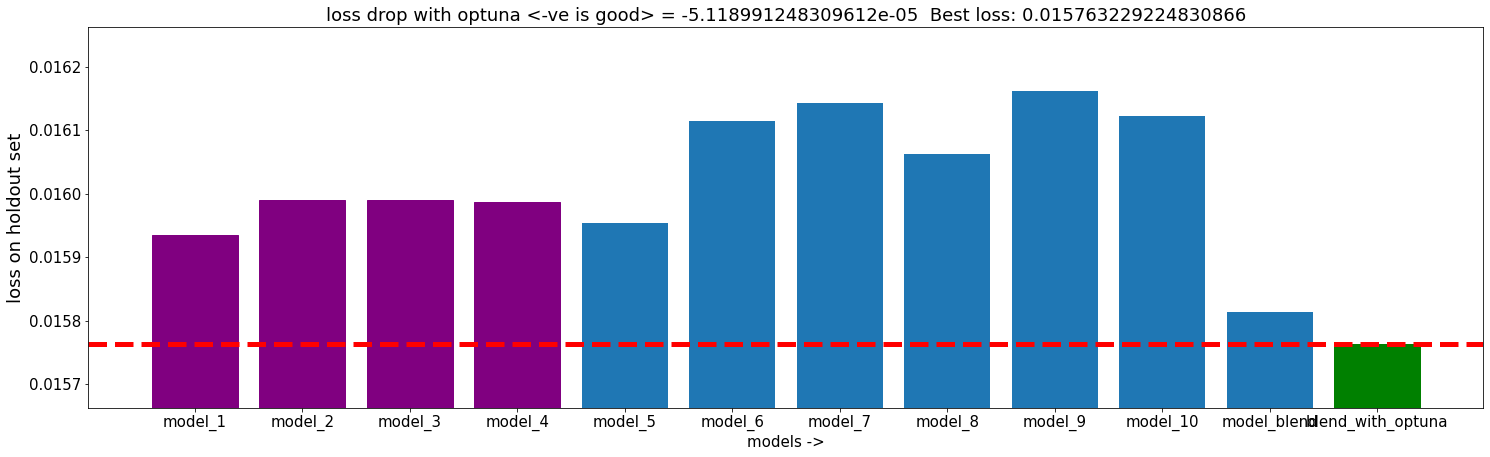

In [73]:
plt.rcParams.update({'font.size': 15})

names = test_val_losses.keys()
vals = test_val_losses.values()

bars = plt.bar(names, vals)

for i in range(5):
    bars[i].set_color("purple")


bars[-1].set_color("g")
plt.ylim(min(vals)- .0001, max(vals) + 0.0001)
plt.ylabel("loss on holdout set", fontsize = 18)
plt.xlabel("models ->", fontsize = 15)
plt.axhline(y = min(vals), linestyle = "--", c = "r", linewidth = 5)
plt.title("loss drop with optuna <-ve is good> = " + str(test_val_losses["blend_with_optuna"] - test_val_losses["model_blend"]) + "  Best loss: " + str(test_val_losses["blend_with_optuna"]))
plt.show()